# Calculate the reaction rates for the primary reactions, as well as the main secondary reactions

In [56]:
from utils import *
import itertools
import pprint
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from scipy.stats import sobol_indices, uniform
from matplotlib import pyplot as plt
import seaborn as sns


# Calculate Startup Time and Net Power Loss

In [57]:
DEBUG = False
param_points = 5 # Number of points for the parametric study


In [58]:
################# Fixed input data
# PARAMETERS FOR THE REACTOR
V_plasma = 150 * unit.m**3  # Plasma volume [m^3]
#Pf_DT = 1000 * unit.MW  # Fusion power for DT reactor [MW]
# PARAMETERS FOR THE FUSION REACTION
tau_p_T = 1 * unit.s  # Tritium confinement time [s]
tau_p_He3 = 1 * unit.s # He3 confinement time [s]
# PARAMETERS FOR THE NET POWER LOSS
eta_th = 0.3  # Thermal efficiency of the reactor [-]
Q = 9  # Fusion gain factor [-] Q = (Pfus-Paux)/Paux
P_aux = 100 * unit.MW  # Auxiliary heating power [MW]

################# Free parameters
n_e_avg = [val * unit.m**-3 for val in np.linspace(1e20, 5e20, param_points)]  # Average electron density [1/m^3]
n_D = n_e_avg  # Deuterium density, same as electron density initially [1/m^3]
T_e_avg = [val* unit.keV for val in np.linspace(14, 50, param_points)]  # Average electron temperature [keV]
I_ST = [val* unit.kg  for val in np.linspace(0.1, 3, param_points) ]# Tritium startup inventory [kg]
TBR = np.linspace(0.5, 1.3, param_points)   # Tritium breeding ratio for DT neutrons [-]
TBR_DDn = np.linspace(0.5, 1, param_points)  # Tritium breeding ratio for DD neutrons [-]
Cost_per_kWh = [val/unit('kWh') for val in np.linspace(0.15, 0.5, param_points)] # [USD] is the cost of electricity

In [59]:
#create an itertools object to iterate over the parameters
p = itertools.product(n_e_avg, T_e_avg, I_ST, TBR, TBR_DDn, Cost_per_kWh)
results = []
#iterate over the parameters to calculate all the values for every combination
for n_e_avg, T_e_avg, I_ST, TBR, TBR_DDn, Cost_per_kWh in p:
    n_D=n_e_avg
    # Calculate the reaction rates
    DD_reaction_rates = calculate_reaction_rates_DD(n_D, T_e_avg, V_plasma, tau_p_T, tau_p_He3)
    # Print the dictionary in the desired format with scientific notation and pretty units
    if DEBUG:
        print("Reaction Rates:")
        for key, value in DD_reaction_rates.items():
            if hasattr(value, "magnitude"):  # Check if the value is a pint.Quantity
                print(f"{key}: {value:.2e~P}")
            else:
                print(f"{key}: {value:.2e}")

    # ESTIMATE TRITIUM PRODUCTION
    # calculate the tritium production rates
    Tdot_fusion = DD_reaction_rates["R_DDp"] - DD_reaction_rates["R_DT"] # [1/s] rate of tritium production due to DDp fusions, considering the losses due to DT neutrons (NB. It is assumed that all the Tritium that is not burnt in DT fusios can be extracted from the system)
    Tdot_breedingDT = TBR * DD_reaction_rates["R_DT"] # [1/s] is the rate of tritium production due to DT neutrons interacting with the breeding blanket
    Tdot_breedingDD = TBR_DDn * DD_reaction_rates["R_DDn"] # [1/s] is the rate of tritium production due to DD neutrons interacting with the Li6 in the breeding blanket
    Tdot_diff = V_plasma * DD_reaction_rates["density_T"] / tau_p_T # [1/s] is the rate of tritium production due to diffusion of tritium in the breeding blanket
    Tdot_tot = Tdot_fusion + Tdot_breedingDT + Tdot_breedingDD # [1/s] is the total rate of tritium production in the system
    if DEBUG:
        print(f"tritium production rates:\n",
            f"    {Tdot_fusion:.2e~P} from the Tritium produced in the DDp channel and not burnt\n",
            f"    {Tdot_breedingDT:.2e~P} from the 14.1 MeV neutrons produced in the DT subchannel and bred (TBR = {TBR})\n",
            f"    {Tdot_breedingDD:.2e~P} from the 2.45 MeV neutrons produced in the DDn channel and bred (TBR_DDn = {TBR_DDn})\n",
            f"    --------------\n",
            f"    {Tdot_tot:.2e~P} total rate of tritium production in the system")
    
    # CALCULATE THE STARTUP TIME
    N_ST = I_ST/molecular_weight_T.to("kg/mol")*N_A # [-] is the number of tritium atoms needed for startup (I_ST[g]/3.016[g/mol]*6.022e23[atoms/mol])
    lambda_T = np.log(2) / ((12.32 * unit.year).to('s'))  # Tritium decay constant [1/s]
    ratio = N_ST * lambda_T / Tdot_tot  # [-] is the ratio of the number of tritium atoms needed for startup to the total rate of tritium production
    if ratio >= 1:
        startup_time = np.inf * unit.s # or np.nan if you prefer
    else:
        startup_time = - (1/lambda_T) * np.log(1 - (ratio))  # Time to reach the inventory target [s]
           
    if DEBUG:
        # Print the startup time in different units using pint's conversion methods
        print(f"Startup time: {startup_time:.2e~P} ({startup_time.to('hour'):.2e~P} = {startup_time.to('day'):.2e~P} = {startup_time.to('year'):.2e~P})")
    
    # CALCULATE THE FUSION POWER
    Pf_DD = DD_reaction_rates["R_DDp"]*E_DDp + DD_reaction_rates["R_DDn"]*E_DDn # [W] is the power produced by DD reactions
    Pf_DD_DT = DD_reaction_rates["R_DT"]*E_DT # [W] is the power produced by DT sub-reactions
    Pf_DD_DHe3 = DD_reaction_rates["R_DHe3"]*E_DHe3 # [W] is the power produced by DHe3 sub-reactions
    Pf_DD_tot = Pf_DD.to('MW') + Pf_DD_DT.to('MW') + Pf_DD_DHe3.to('MW') # [W] is the total power produced in a DD reactor
    Pf_DT = fusion_power_50D50T(n_e_avg, T_e_avg, E_DT, V_plasma) # [W] is the power produced by DT reactions (the 1e-6 factor is needed to convert <sigmav> from cm^3/s to m^3/s)
    # N.B. this is the total fusion power of a 50%D-50%T plasma in the selected conditions - it may not correspond to the expected 1000 MW power due to the use of average values of T and n_e
    if DEBUG:
        print(f"Pf_DD_tot: {Pf_DD_tot:.2f~P} \n(of which {Pf_DD.to('MW'):.2f~P} is from DD reactions, {Pf_DD_DT.to('MW'):.2f~P} is from DT sub-reactions and {Pf_DD_DHe3.to('MW'):.2f~P} is from DHe3 sub-reactions)")
        print(f"Pf_DT: {Pf_DT.to('MW'):.2f~P}\n(considering a 50%D-50%T plasma and using the formula (n_e_avg/2)^2 * <sigmav>_DT * E_DT * V_plasma)")
    
    # CALCULATE THE NET ELECTRICAL POWER
    P_e_net_DD, Q_DD = calculate_P_e_net_Paux(Pf_DD, P_aux, eta_th) # [W] is the net electrical power produced by the reactor
    P_e_net_DT, Q_DT = calculate_P_e_net_Paux(Pf_DT, P_aux, eta_th) # [W] is the net electrical power produced by the reactor
    E_lost = (P_e_net_DT - P_e_net_DD)*startup_time # [J] is the energy lost during the startup time operation in DD
    Dollar_lost = Cost_per_kWh.to('1/J') * E_lost # [USD] is the cost of the lost energy during the startup time operation in DD
    if DEBUG:
        print(f"P_e_net_DD: {P_e_net_DD.to('MW'):.2f~P}, Q_DD: {Q_DD.to(''):.2f~P}, P_aux(imposed): {P_aux.to('MW'):.2f~P}")
        print(f"P_e_net_DT: {P_e_net_DT.to('MW'):.2f~P}, Q_DT: {Q_DT.to(''):.2f~P}, P_aux(imposed): {P_aux.to('MW'):.2f~P}")
        # Condsider P_aux fixed for both the DD and DT reactions
        print(f"E_lost: {E_lost.to('MJ'):.2e~P}")
        print(f"$ lost: {Dollar_lost:.2f~P} USD = {Dollar_lost/1e6:.2f~P} million USD")  
    
    
    # Collect all values as magnitudes (convert units if needed)
    row = [
        n_e_avg.magnitude/1e20, T_e_avg.magnitude, I_ST.magnitude, TBR, TBR_DDn, Cost_per_kWh.magnitude,
        Tdot_fusion.magnitude, Tdot_breedingDT.magnitude, Tdot_breedingDD.magnitude, Tdot_diff.magnitude, Tdot_tot.magnitude,
        startup_time.to('hour').magnitude,  # or .magnitude for seconds
        Pf_DD.to('MW').magnitude, 
        Pf_DD_DT.to('MW').magnitude, 
        Pf_DD_DHe3.to('MW').magnitude,
        Pf_DD_tot.magnitude,
        Pf_DT.to('MW').magnitude,
        P_e_net_DD.to('MW').magnitude, 
        Q_DD, 
        P_e_net_DT.to('MW').magnitude, 
        Q_DT,
        E_lost.to('MJ').magnitude, 
        Dollar_lost.magnitude
    ]
    results.append(row)

# Convert to array and save
results = np.array(results)
header = "n_e20_avg[1/m^3],T_e_avg[keV],I_ST[kg],TBR,TBR_DDn,Cost_per_kWh[USD/MWh],Tdot_fusion[T/s],Tdot_breedingDT[T/s],Tdot_breedingDD[T/s],Tdot_diff[T/s],Tdot_tot[T/s],startup_time[hour],Pf_DD[MW],Pf_DD_DT[MW],Pf_DD_DHe3[MW],Pf_DD_tot[MW],Pf_DT[MW],P_e_net_DD[MW],Q_DD,P_e_net_DT[MW],Q_DT,E_lost[MJ],Dollar_lost[USD]"
np.savetxt("parametric_results.csv", results, delimiter=",", header=header, comments='')

In [60]:
df = pd.read_csv("parametric_results.csv")
#print the parameters leading to a value of Dollar_lost greater than 10 billion USD

print(df[df["Dollar_lost[USD]"] >= 1e15])

cols = [
    "n_e20_avg[1/m^3]","T_e_avg[keV]","I_ST[kg]","TBR","TBR_DDn","Cost_per_kWh[USD/MWh]",
    "Dollar_lost[USD]"
]
df_filtered = df[df["Dollar_lost[USD]"] <= 2e10]

df_plot = df_filtered[cols]

fig = go.Figure(
    data=go.Parcoords(
        line=dict(
            color=df_plot["Dollar_lost[USD]"],
            colorscale='temps',
            showscale=True
        ),
        dimensions=[
            dict(label="n_e20_avg [1/m^3]", values=df_plot["n_e20_avg[1/m^3]"]),
            dict(label="T_e_avg [keV]", values=df_plot["T_e_avg[keV]"]),
            dict(label="I_startup [kg]", values=df_plot["I_ST[kg]"]),
            dict(label="TBR", values=df_plot["TBR"]),
            dict(label="TBR_DDn", values=df_plot["TBR_DDn"]),
            dict(label='C_e[USD/MWh]', values=df_plot["Cost_per_kWh[USD/MWh]"]),
            dict(label="Unrealized gains + expenses [B$]", values=df_plot["Dollar_lost[USD]"]/1e9),
        ],
    )
)

fig.show()


Empty DataFrame
Columns: [n_e20_avg[1/m^3], T_e_avg[keV], I_ST[kg], TBR, TBR_DDn, Cost_per_kWh[USD/MWh], Tdot_fusion[T/s], Tdot_breedingDT[T/s], Tdot_breedingDD[T/s], Tdot_diff[T/s], Tdot_tot[T/s], startup_time[hour], Pf_DD[MW], Pf_DD_DT[MW], Pf_DD_DHe3[MW], Pf_DD_tot[MW], Pf_DT[MW], P_e_net_DD[MW], Q_DD, P_e_net_DT[MW], Q_DT, E_lost[MJ], Dollar_lost[USD]]
Index: []

[0 rows x 23 columns]


In [61]:
# Identify the lowest value in ["Dollar_lost[USD]"], and print the corresponding parameters
min_value = df["Dollar_lost[USD]"].min()
min_row = df[df["Dollar_lost[USD]"] == min_value].iloc[0]
print("\nParameters leading to the lowest Dollar_lost:")
for col in cols:
    print(f"{col}: {min_row[col]}")


Parameters leading to the lowest Dollar_lost:
n_e20_avg[1/m^3]: 5.0
T_e_avg[keV]: 50.0
I_ST[kg]: 0.1
TBR: 1.3
TBR_DDn: 1.0
Cost_per_kWh[USD/MWh]: 0.15
Dollar_lost[USD]: 13650209.129375596


In [62]:
df

,n_e20_avg[1/m^3],T_e_avg[keV],I_ST[kg],TBR,TBR_DDn,Cost_per_kWh[USD/MWh],Tdot_fusion[T/s],Tdot_breedingDT[T/s],Tdot_breedingDD[T/s],Tdot_diff[T/s],...,Pf_DD_DT[MW],Pf_DD_DHe3[MW],Pf_DD_tot[MW],Pf_DT[MW],P_e_net_DD[MW],Q_DD,P_e_net_DT[MW],Q_DT,E_lost[MJ],Dollar_lost[USD]
0,1.0,14.0,0.1,0.5,0.5,0.1500,8.849335e+17,1.064328e+16,4.809208e+17,8.850220e+17,...,0.060025,0.000248,1.178598,254.360266,-99.664502,-0.988817,-23.691920,1.543603,1.116550e+09,4.652293e+07
1,1.0,14.0,0.1,0.5,0.5,0.2375,8.849335e+17,1.064328e+16,4.809208e+17,8.850220e+17,...,0.060025,0.000248,1.178598,254.360266,-99.664502,-0.988817,-23.691920,1.543603,1.116550e+09,7.366130e+07
2,1.0,14.0,0.1,0.5,0.5,0.3250,8.849335e+17,1.064328e+16,4.809208e+17,8.850220e+17,...,0.060025,0.000248,1.178598,254.360266,-99.664502,-0.988817,-23.691920,1.543603,1.116550e+09,1.007997e+08
3,1.0,14.0,0.1,0.5,0.5,0.4125,8.849335e+17,1.064328e+16,4.809208e+17,8.850220e+17,...,0.060025,0.000248,1.178598,254.360266,-99.664502,-0.988817,-23.691920,1.543603,1.116550e+09,1.279380e+08
4,1.0,14.0,0.1,0.5,0.5,0.5000,8.849335e+17,1.064328e+16,4.809208e+17,8.850220e+17,...,0.060025,0.000248,1.178598,254.360266,-99.664502,-0.988817,-23.691920,1.543603,1.116550e+09,1.550764e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15620,5.0,50.0,3.0,1.3,1.0,0.1500,1.287446e+20,7.234454e+19,2.124747e+20,1.287574e+20,...,156.922586,16.570239,410.337977,22853.770760,-28.946454,1.368452,6756.131228,227.537708,9.840439e+09,4.100183e+08
15621,5.0,50.0,3.0,1.3,1.0,0.2375,1.287446e+20,7.234454e+19,2.124747e+20,1.287574e+20,...,156.922586,16.570239,410.337977,22853.770760,-28.946454,1.368452,6756.131228,227.537708,9.840439e+09,6.491956e+08
15622,5.0,50.0,3.0,1.3,1.0,0.3250,1.287446e+20,7.234454e+19,2.124747e+20,1.287574e+20,...,156.922586,16.570239,410.337977,22853.770760,-28.946454,1.368452,6756.131228,227.537708,9.840439e+09,8.883729e+08
15623,5.0,50.0,3.0,1.3,1.0,0.4125,1.287446e+20,7.234454e+19,2.124747e+20,1.287574e+20,...,156.922586,16.570239,410.337977,22853.770760,-28.946454,1.368452,6756.131228,227.537708,9.840439e+09,1.127550e+09


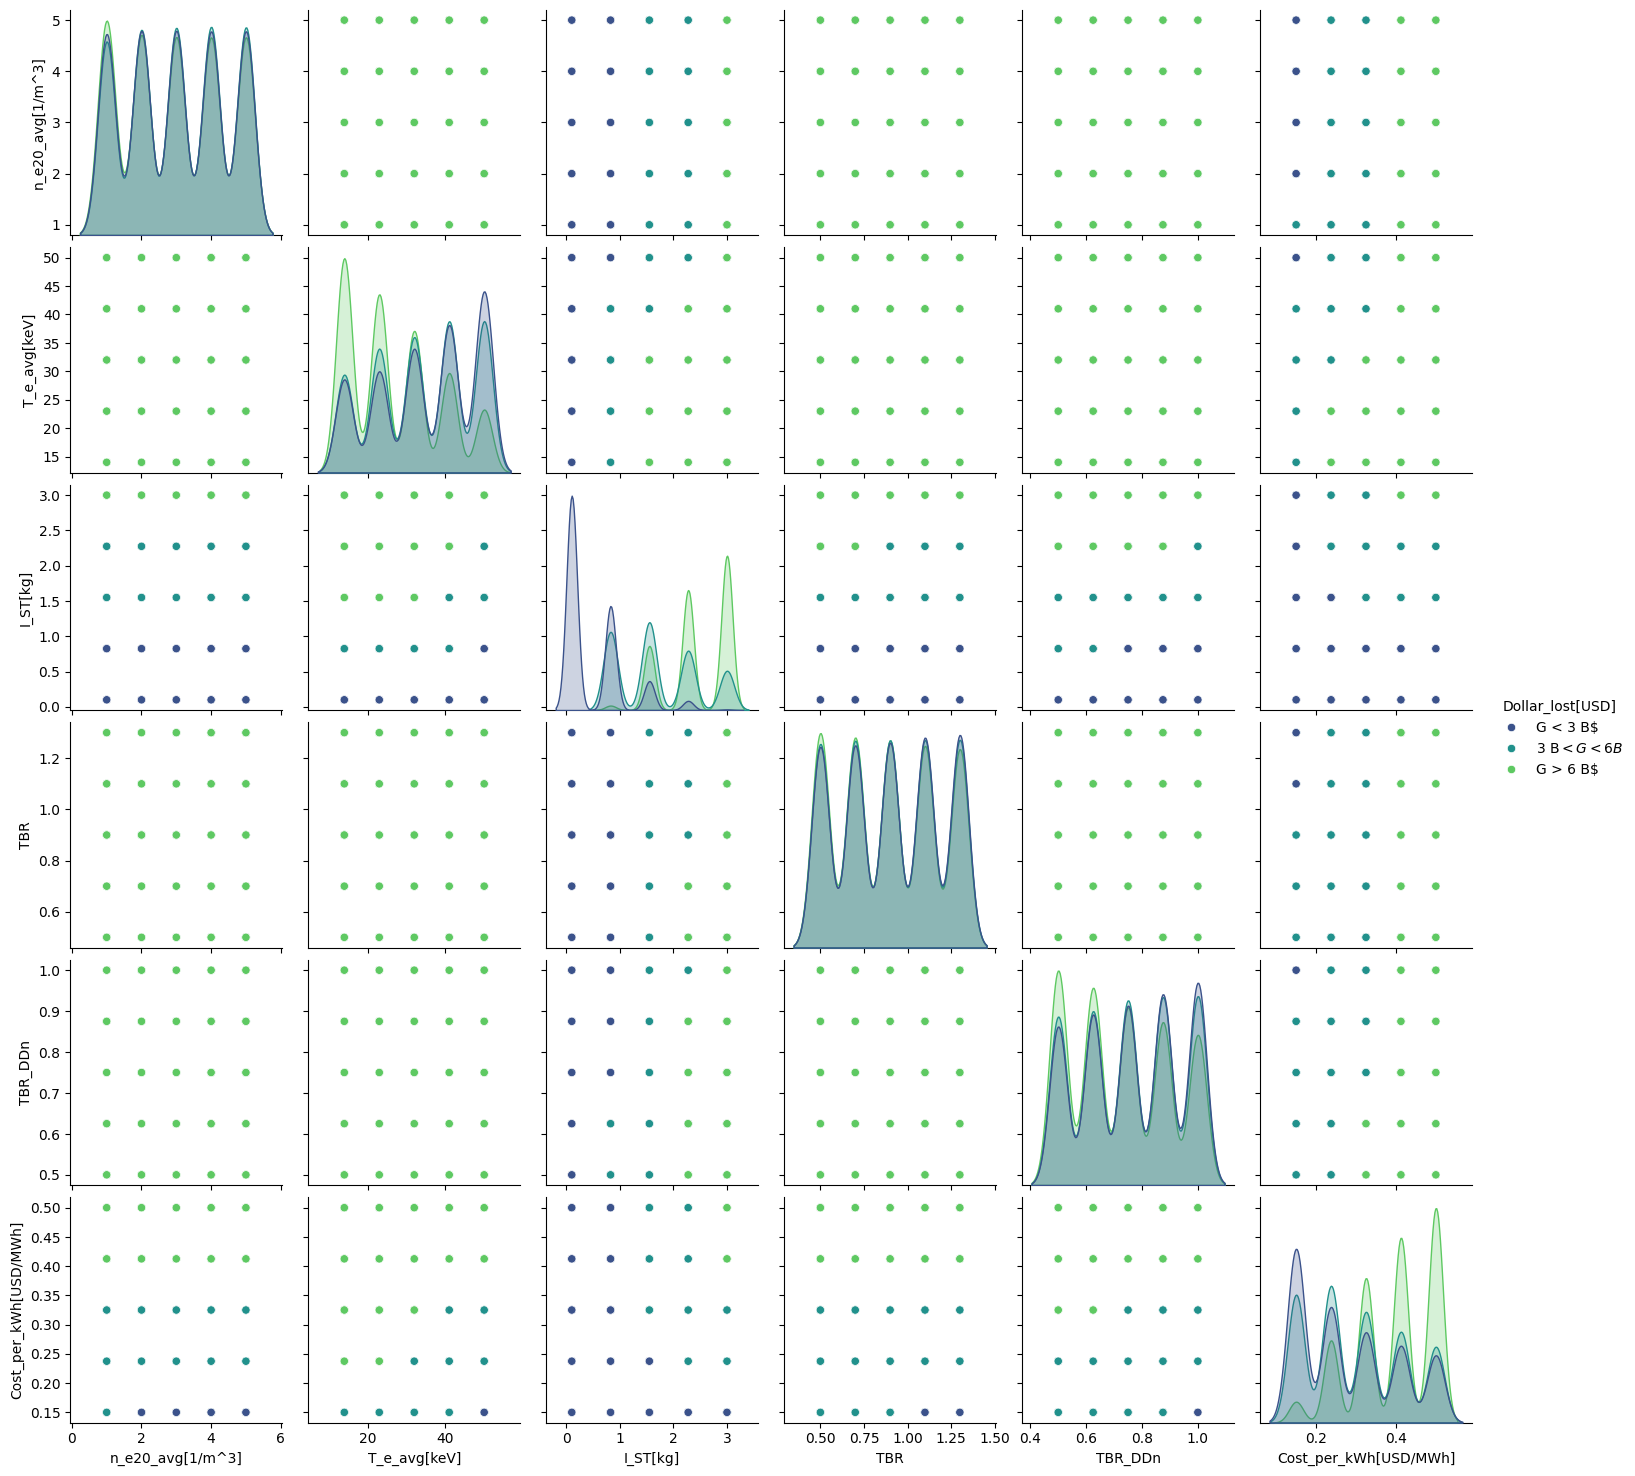

In [63]:
# Pairplot with seaborn
# Split it 3 bins
df_filtered["Dollar_lost[USD]"] = pd.qcut(df_filtered["Dollar_lost[USD]"], q=3, labels=["G < 3 B$", "3 B$ < G < 6 B$", "G > 6 B$"])
sns.pairplot(df_filtered[cols], hue="Dollar_lost[USD]", palette='viridis', kind='scatter', diag_kind='kde', markers='o', height=2.5)
plt.savefig("outputs/pairplot.pdf", dpi=300, bbox_inches='tight')
plt.show()
